In [2]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# Importing GemPy, which takes really long
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

from gempy import GridClass

In [3]:
# set basic parameters 

ext = [0,10,0,10,0,10] #extend
res = [10,10,10] #resolution
n = 20 #number of training values
val_rng = [0,20] #range of training values

In [4]:
# create empty Grid with defined extension and resolution as a gempy GridClass. 
# note that this grid is an np.ndarray containing x,y,z vectors (size x*3)

g = GridClass
g.create_regular_grid_3d(g,ext,res);

In [5]:
# creating array of input values to be shown at given coordinates, basis for (Co)Kriging

# c = np.arange(0, 1000, 1)
# c = np.random.randint(0, 100, 1000)

# create an (empty) array of size equal to grid number of coordinates 
prop1 = np.zeros(res[0]*res[1]*res[2])
prop2 = np.zeros(res[0]*res[1]*res[2])

#fill prop with n training values in given range (val_rng)
for i in range (n):
    rand_pos = np.random.randint(0,res[0]*res[1]*res[2])
    prop1[rand_pos]= np.random.randint(val_rng[0],val_rng[1])
    prop2[rand_pos]= np.random.randint(val_rng[0],val_rng[1])


In [6]:
# extract x,y,z values as 1d array for visualization, probably not necessary

x=g.values[:,0]
y=g.values[:,1]
z=g.values[:,2]

In [7]:
# creating list of lithologies, one with strings, one with assigned numbers for calc
lith = list()
lith_num = list()

for j in range (res[0]*res[1]*res[2]):
    if z[j]>=3 and z[j]<=6: # range for lith values for seperation (just arbitrary)
        lith.append("shale")
        lith_num.append(1)
    else:
        lith.append("sand")
        lith_num.append(2)

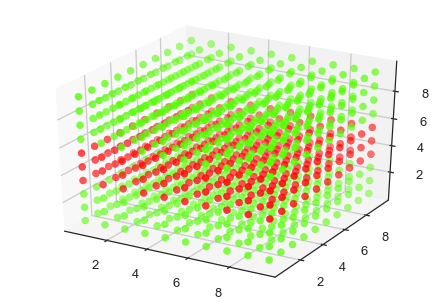

In [8]:
# basic visualization to see connection between coord and values or coord and lithologies
fig = pyplot.figure()

ax = Axes3D(fig)
ax.scatter3D(xs=x,ys=y,zs=z,c=lith_num, s=50, cmap='prism')


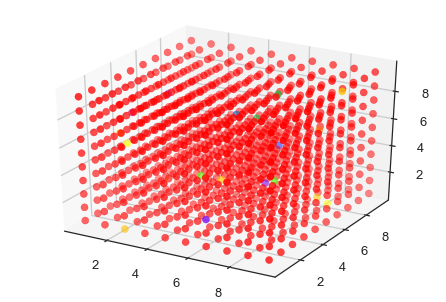

In [9]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.scatter3D(xs=x,ys=y,zs=z,c=prop1, s=50, cmap='prism')

In [10]:
# creating my own pandas df and see if I can get everything in there
import pandas as pd

In [11]:
# creating dataframe and populating it with our data
d = {'X': x, 'Y': y, 'Z': z, 'prop1': prop1, 'prop2': prop2, 'lith': lith, 'lith_num': lith_num}
df = pd.DataFrame(data=d)

In [12]:
# create reduced dataframe with only one lithology
df_cut = df.loc[df['lith_num'] == 1]

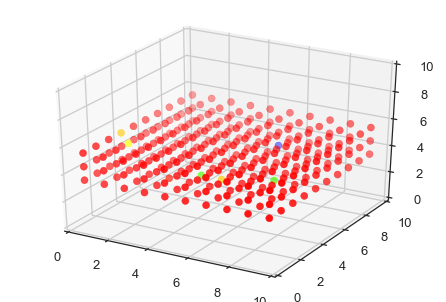

In [13]:
# visualization
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,10)
ax.axes.set_xlim3d(0,10)
ax.axes.set_ylim3d(0,10)
ax.scatter3D(xs=df_cut.X,ys=df_cut.Y,zs=df_cut.Z, c=df_cut.prop1, s=50, cmap='prism')

In [14]:
df_cut_vals = df_cut.loc[df['prop1'] != 0]

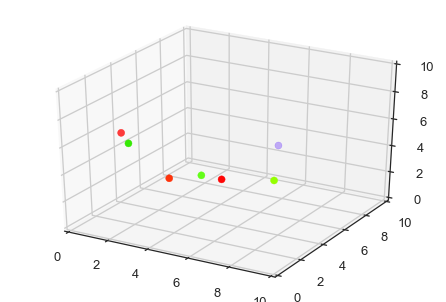

In [15]:
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,10)
ax.axes.set_xlim3d(0,10)
ax.axes.set_ylim3d(0,10)
ax.scatter3D(xs=df_cut_vals.X,ys=df_cut_vals.Y,zs=df_cut_vals.Z, c=df_cut_vals.prop1, s=50, cmap='prism')

In [16]:
df_cut_vals.shape

(7, 7)

In [17]:
df_cut_vals

,X,Y,Z,lith,lith_num,prop1,prop2
35,0.5,3.5,5.5,shale,1,2.0,1.0
125,1.5,2.5,5.5,shale,1,7.0,12.0
323,3.5,2.5,3.5,shale,1,5.0,8.0
433,4.5,3.5,3.5,shale,1,17.0,18.0
533,5.5,3.5,3.5,shale,1,2.0,6.0
583,5.5,8.5,3.5,shale,1,6.0,5.0
743,7.5,4.5,3.5,shale,1,4.0,3.0


In [18]:
from gempy import coKriging

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [19]:
exp_var = gp.coKriging.compute_crossvariogram(df_cut_vals, ("prop1","prop2"))

C:\Users\Jan\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [20]:
exp_var.head()

,prop1-prop1,prop1-prop2,prop2-prop1,prop2-prop2,lags
0,22.693878,26.77551,26.77551,28.816327,1.000000
1,22.693878,26.77551,26.77551,28.816327,1.064786
2,22.693878,26.77551,26.77551,28.816327,1.133769
3,22.693878,26.77551,26.77551,28.816327,1.207222
4,22.693878,26.77551,26.77551,28.816327,1.285433


C:\Users\Jan\Anaconda3\lib\site-packages\pandas\plotting\_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


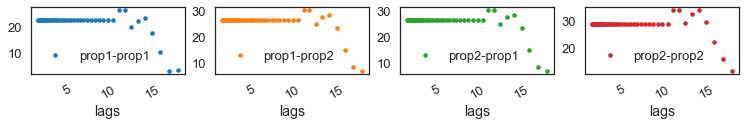

In [21]:
exp_var.plot(x='lags', y=exp_var.columns[:-1], subplots=True,kind='line',style='.',layout=(5,5),figsize=(16,8));

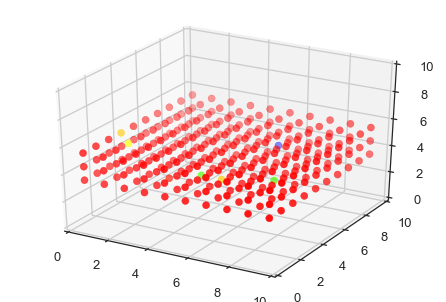

In [22]:
#SGS idea
# visualization
fig = pyplot.figure()
ax = Axes3D(fig)
ax.axes.set_zlim3d(0,10)
ax.axes.set_xlim3d(0,10)
ax.axes.set_ylim3d(0,10)
ax.scatter3D(xs=df_cut.X,ys=df_cut.Y,zs=df_cut.Z, c=df_cut.prop1, s=50, cmap='prism')

In [23]:
df_cut_vals = df_cut.loc[df['prop1'] != 0]
df_cut_zeros = df_cut.loc[df['prop1'] == 0]

In [29]:
df_cut_zeros.shape

(293, 7)

In [25]:
df_cut_zeros.values[2,:]

array([0.5, 0.5, 5.5, 'shale', 1, 0.0, 0.0], dtype=object)